# Baseline Model: XGBoost
In this notebook, we forecast the fastest Bitcoin transaction fee (sats/vByte) using XGBoost Regressor. 

### Why We Chose XGBoost as a Baseline Model
We selected XGBoost as one of our baseline models because it provides a strong balance between performance, interpretability, and efficiency when working with structured tabular data. Unlike traditional linear models, XGBoost can effectively capture non-linear relationships and complex interactions between features, which includes both temporal patterns (via lag features) and contextual signals (like mempool and market conditions). 

Our target variable recommended_fee_fastestFee is not only time-dependent but also correlates with other recommended fee rates (e.g., halfHourFee, hourFee, etc.), which serve as important external features. When there are known correlations between the target and input features in the presence of redundancy or nonlinearity, XGBoost offers both high performance and interpretability. The exploratory data analysis confirms these relationships and reveals substantial variability and temporal structure in the data, which makes simpler linear models less effective. XGBoost, in contrast, is robust to multicollinearity, handles missing data gracefully, and naturally incorporates lag features. Additionally, it provides useful feature importance insights and performs well with minimal preprocessing, which makes it a practical and reliable starting point for benchmarking more complex forecasting models.

By tuning key hyperparameters and evaluating the model with MAE and RMSE, we can gauge how well tree-based methods handle fee rate prediction and set a meaningful performance benchmark.


### Import required libraries

In [21]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
import joblib
import json

In [22]:
import sys
sys.path.append("../src")
from XGBoost import data_split, build_random_search, create_lag_features_fast,evaluate_model,plot_result,evaluate_best_model,calculate_metrics
from preprocess_raw_parquet import preprocess_raw_parquet

### Load data
To ensure that we only train on complete data, we drop the lag rows which contain NaN values introduced by lag feature creation. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [23]:
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df.dropna(inplace = True)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create lag features

We will need lagging feature for XGboost. Since each hour has 4 data points (60 ÷ 15), 48 hours = 192 lag steps.

In [24]:
lags = range(1, 193)  # 48 hours of 15-minute intervals
df = create_lag_features_fast(df, 'recommended_fee_fastestFee', lags)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,recommended_fee_fastestFee_lag_183,recommended_fee_fastestFee_lag_184,recommended_fee_fastestFee_lag_185,recommended_fee_fastestFee_lag_186,recommended_fee_fastestFee_lag_187,recommended_fee_fastestFee_lag_188,recommended_fee_fastestFee_lag_189,recommended_fee_fastestFee_lag_190,recommended_fee_fastestFee_lag_191,recommended_fee_fastestFee_lag_192
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Optimization - Find the best params

### Params
We choose RandomizedSearch to optimize the model. It allows us to explore a broader space efficiently with fewer iterations. Here are the ranges of parameters.

n_estimators: [50, 100, 150] 
It controls the number of boosting rounds. Small values (50) may underfit, while higher values (150) may lead to better performance but risk overfitting. Keeping this modest helps reduce training time and keeps the search space focused.

max_depth: [1, 2, 3] 
It controls the maximum depth of individual trees. Shallow trees (1–3) are less likely to overfit and are more interpretable. Especially appropriate when the number of features is high and the time resolution is short (5-min data), helping avoid overly complex trees.

learning_rate: [0.01, 0.05, 0.1] 
Learning rate shrinks the contribution of each tree. Lower values slow down learning but improve generalization. Chosen to strike a balance between convergence speed and model stability.

subsample: [0.6, 0.8, 0.9] 
Fraction of rows used per tree. It introduces randomness ,helping prevent overfitting and improving robustness. 0.6–0.9 allows experimentation with more regularized models.

colsample_bytree: [0.6, 0.8, 0.9] 
Fraction of columns (features) used to build each tree. Especially helpful when there are many features. It helps prevent overfitting by decorrelating trees.

gamma: [1, 3, 5] 
Minimum loss reduction to make a split. It acts as a regularizer to control tree growth. Higher values force the model to make only meaningful splits.

reg_lambda: [5, 10, 20] 
L2 regularization on leaf weights. It prevents overly large weights, stabilizing the model especially with correlated features. It also helps handle multicollinearity and improve generalization.

reg_alpha: [5, 10, 20] 
L1 regularization (sparsity). It encourages feature selection by zeroing out less useful ones, and is particularly useful in high-dimensional datasets (e.g., many lag features).

In [25]:
param_dist = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [1, 2, 3],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__subsample': [0.6, 0.8, 0.9],
    'estimator__colsample_bytree': [0.6, 0.8, 0.9],
    'estimator__gamma': [1, 3, 5],
    'estimator__reg_lambda': [5, 10, 20],
    'estimator__reg_alpha': [5, 10, 20]
}


### Sliding window

The dataset contains 10-week data. Use each of the five weeks data to train the model. Fixed-size window helps assess how well model generalizes across changing conditions.

In [26]:
fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)

In [ ]:
# metrics_per_week, avg_metrics,y_test,y_pred = evaluate_model(df,param_dist,interval=15,weeks=10,fh=fh,sliding=1)
# # save the result
# with open("../results/tables/xgboost/sliding_metrics_list.json", "w") as f:
#     json.dump(metrics_per_week, f, indent=4)
# with open("../results/tables/xgboost/sliding_avg_metrics_list.json", "w") as f:
#     json.dump(avg_metrics, f, indent=4)

In [28]:
with open("../results/tables/xgboost/sliding_avg_metrics_list.json", "r") as f:
    avg_metrics = json.load(f)
print("\nAverage metrics over all weeks:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")


Average metrics over all weeks:
avg_mae: 2.7261
avg_rmse: 3.9034
avg_mape: 0.6238
avg_mae_std: 8.1782
base_avg_mae: 1.8979
base_avg_rmse: 3.3427
base_avg_mape: 0.3678
base_avg_mae_std: 5.6937


## Expanding window

The dataset contains 10-week data. Start with the first week and train the model five times by progressively adding one more week each time. This methods simulates real-world scenario as more historical data becomes available and tests whether model improves as it learns from a growing dataset. 

In [ ]:
# metrics_per_week, avg_metrics,y_test,y_pred = evaluate_model(df,param_dist,interval=15,weeks=10,fh=fh,sliding=0)
# # save the result
# with open("../results/tables/xgboost/expanding_metrics_list.json", "w") as f:
#     json.dump(metrics_per_week, f, indent=4)
# with open("../results/tables/xgboost/expanding_avg_metrics_list.json", "w") as f:
#     json.dump(avg_metrics, f, indent=4)

In [30]:
with open("../results/tables/xgboost/expanding_avg_metrics_list.json", "r") as f:
    avg_metrics = json.load(f)
print("\nAverage metrics over all weeks:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")


Average metrics over all weeks:
avg_mae: 2.5350
avg_rmse: 3.6764
avg_mape: 0.6071
avg_mae_std: 7.6049
base_avg_mae: 1.9278
base_avg_rmse: 3.3702
base_avg_mape: 0.3944
base_avg_mae_std: 5.7833


### The best model

Fianlly, we try to train with expanding window on the whole data set. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [31]:
df_new = df.iloc[:-96]

In [32]:
loaded_model = joblib.load("../results/models/xgboost.pkl")
metrics,y_test,y_pred = calculate_metrics(loaded_model,df_new,15,fh)

In [33]:
print("\nMetrics:")
for k, v in metrics[0].items():
    print(f"{k}: {v:.4f}")


Metrics:
mae: 0.7787
rmse: 1.0410
mape: 0.3469
mae_std: 2.3362
base_mae: 0.9097
base_rmse: 1.1087
base_mape: 0.5078
base_mae_std: 2.7292


### Plot

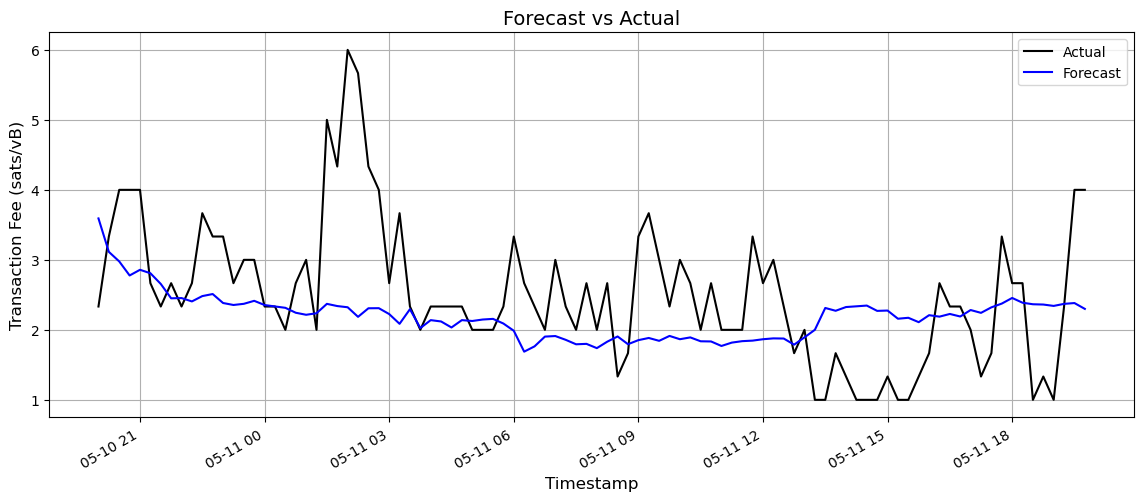

In [34]:
plot_result(y_test=y_test,y_pred=y_pred)

### Conclusion

Based on the average metrics, expanding window performs better than sliding window across all metrics. Moreover, it slightly outperforms baseline (i.e. global median) within the 5-weeks data available. However, the performance is still far from ideal.